# EXPLORATION 15

### Google OCR API

In [1]:
def detect_text(path):
    global google_OCR_API_text_list
    google_OCR_API_text_list = []
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))
       google_OCR_API_text_list.append(text.description)

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [2]:
# 로컬 환경에서는 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# 클라우드 환경에서는 무시해도 좋습니다
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

total 53316
-rw-r--r-- 1 root root  1325716 Feb 28 05:42 '[Ex_15]OCR.ipynb'
-rw-r--r-- 1 root root     2335 Feb 27 14:54  my_google_api_key.json
drwxr-xr-x 2 root root     4096 Feb 28 03:21  tesseract_crop
-rw-r--r-- 1 root root   122719 Feb 27 15:22  test_image2.png
-rw-r--r-- 1 root root  5171334 Feb 25 02:40  test_image.png
-rw-r--r-- 1 root root    42020 Feb 27 16:01  test_image_text.png
-rw-r--r-- 1 root root 11674867 Feb 28 03:16  Test_mask.png
-rw-r--r-- 1 root root  7994084 Feb 28 04:17  TM_1.png
drwxr-xr-x 2 root root     4096 Feb 28 05:03  TM_1_tesseract_crop
-rw-r--r-- 1 root root  8483658 Feb 28 04:17  TM_2.png
drwxr-xr-x 2 root root     4096 Feb 28 05:11  TM_2_tesseract_crop
-rw-r--r-- 1 root root  7781739 Feb 28 04:17  TM_3.png
-rw-r--r-- 1 root root  7686517 Feb 28 04:17  TM_4.png
-rw-r--r-- 1 root root  4277862 Feb 28 04:17  TM_5.png
Texts:

"DEAD
END
"

"DEAD"

"END"
bounds: (756,672),(1271,672),(1271,871),(756,871)


### Keras-OCR

In [3]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [4]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

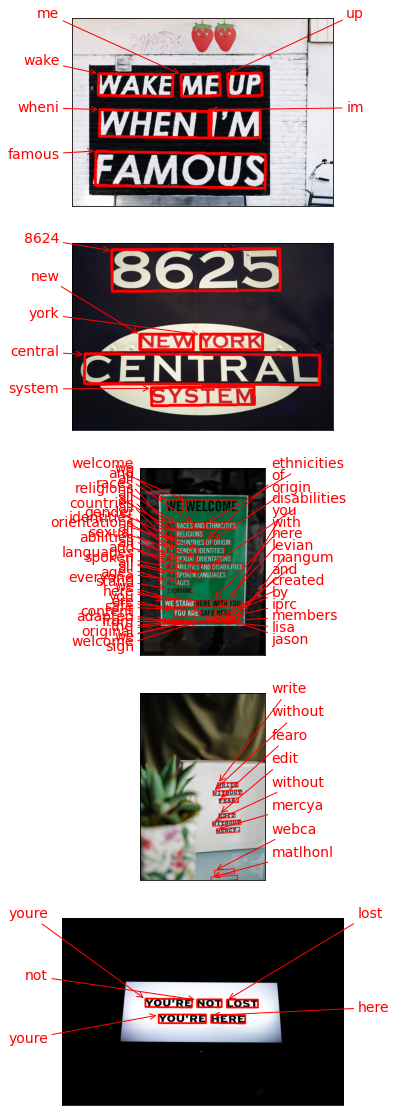

In [5]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

### 테서랙트(Tesseract)

#### 테서랙트로 문자 검출하고 이미지 자르기 (datection)

In [6]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python/tesseract_crop'
img_file_path = os.getenv('HOME') + '/aiffel/ocr_python/test_image_text.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/tesseract_crop/0000.png
/aiffel/aiffel/ocr_python/tesseract_crop/0001.png
/aiffel/aiffel/ocr_python/tesseract_crop/0002.png
/aiffel/aiffel/ocr_python/tesseract_crop/0003.png
/aiffel/aiffel/ocr_python/tesseract_crop/0004.png
/aiffel/aiffel/ocr_python/tesseract_crop/0005.png
/aiffel/aiffel/ocr_python/tesseract_crop/0006.png
/aiffel/aiffel/ocr_python/tesseract_crop/0007.png
/aiffel/aiffel/ocr_python/tesseract_crop/0008.png
/aiffel/aiffel/ocr_python/tesseract_crop/0009.png
/aiffel/aiffel/ocr_python/tesseract_crop/0010.png
/aiffel/aiffel/ocr_python/tesseract_crop/0011.png
/aiffel/aiffel/ocr_python/tesseract_crop/0012.png
/aiffel/aiffel/ocr_python/tesseract_crop/0013.png
/aiffel/aiffel/ocr_python/tesseract_crop/0014.png
/aiffel/aiffel/ocr_python/tesseract_crop/0015.png
/aiffel/aiffel/ocr_python/tesseract_crop/0016.png
/aiffel/aiffel/ocr_python/tesseract_crop/0017.png
/aiffel/aiffel/ocr_python/tesseract_crop/0018.png
/aiffel/aiffel/ocr_python/tesseract_crop/0019.png


#### 테서랙트로 잘린 이미지에서 단어 인식하기

In [7]:
def recognize_images(cropped_image_path_list):
    global text_list
    text_list = []
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
        text_list.append(recognized_data['text'][:-2])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

Mild

Splendour

of

the

various-vested

Night!

Mother

ot

wiidly-working

Visions!

hail!


watch

thy

gliding,

while

with

watery

light

Thy

weak

cye

glimmers

through

a

fieecy

veil;

And

when

thou

lovest

thy

pale

orb

to

shroud

Behind

the

gather d

blackness

lost

On

high;

And

when

thou

dartest

from

the

wind-rent

cloud

Thy

placid

lightning

Oo er

the

awaken’d

Sky.

Done


In [8]:
text_list[1]

'Splendour'

In [9]:
import keras_ocr
import pytesseract

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


# Step 0. 구현하고자 하는 서비스 기획
### 한글과, 영문이 혼용 되어 있는 카페 메뉴판의 글자를 인식하기
- 혼용된 글자를 인식만 성공시킨다면, 후에, 이 기술을 가지고, 영어를 못하는, 혹은 반대로 한글을 못하는 사람들에게 자동으로 번역하여 구현할 수 있으며, 더 나아가, 다른 나라 언어로도 쉽게 번역 가능 할 것을 생각하여 혼용 글자를 인식 하고자 하는 목표를 세웠습니다.

### 평가기준
- 한글은 한글, 영문은 영문에 대한 인식률을 확인해 본다.
- 또한 카페 조명 특성상 조명에 가려진 노이즈도 인식하는지 확인해 본다.
- 또한, 아주 작은 글자까지 인식을 하는지 확인해 본다.

# Step1. 검증용 데이터셋 준비

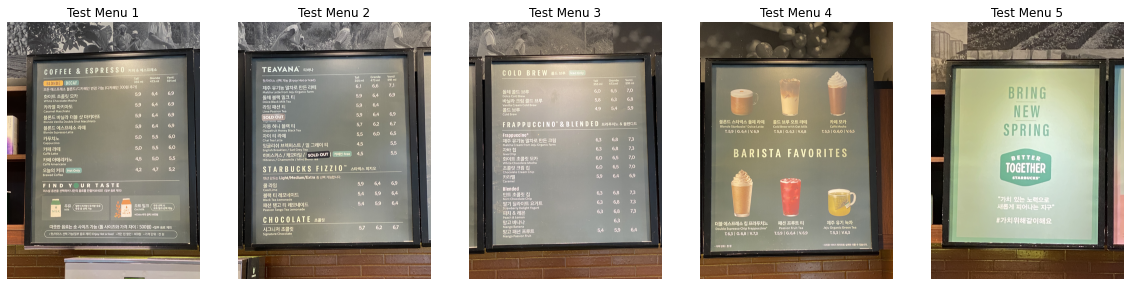

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

fig = plt.figure(figsize = (20,20))
rows = 1
cols = 5

TM1 = os.getenv('HOME')+'/aiffel/ocr_python/TM_1.png'
TM2 = os.getenv('HOME')+'/aiffel/ocr_python/TM_2.png'
TM3 = os.getenv('HOME')+'/aiffel/ocr_python/TM_3.png'
TM4 = os.getenv('HOME')+'/aiffel/ocr_python/TM_4.png'
TM5 = os.getenv('HOME')+'/aiffel/ocr_python/TM_5.png'

img1 = cv2.imread(TM1)
img2 = cv2.imread(TM2)
img3 = cv2.imread(TM3)
img4 = cv2.imread(TM4)
img5 = cv2.imread(TM5)
 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title('Test Menu 1')
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title('Test Menu 2')
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax3.set_title('Test Menu 3')
ax3.axis("off")

ax4 = fig.add_subplot(rows, cols, 4)
ax4.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
ax4.set_title('Test Menu 4')
ax4.axis("off")

ax5 = fig.add_subplot(rows, cols, 5)
ax5.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
ax5.set_title('Test Menu 5')
ax5.axis("off")
 
plt.show()

# Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택사항)

## Google OCR API

In [31]:
# Google OCR API
detect_text(TM1)
google_OCR_API_text_list_TM1 = google_OCR_API_text_list
detect_text(TM2)
google_OCR_API_text_list_TM2 = google_OCR_API_text_list
detect_text(TM3)
google_OCR_API_text_list_TM3 = google_OCR_API_text_list
detect_text(TM4)
google_OCR_API_text_list_TM4 = google_OCR_API_text_list
detect_text(TM5)
google_OCR_API_text_list_TM5 = google_OCR_API_text_list

Texts:

"COFFEE & ESPRESS0 & 0|AA
Tall
355 ml
Grande
473 ml
Venti
591 ml
BLONDE
DECAF
모든 에스프레소 블론드/디카페인 변경 가능 (디카페인 300원 추가)
5,9
6,4
6,9
화이트 초콜릿 모카
White Chocolate Mocha
5,9
6,4
6,9
카라멜 마키아또
Caramel Macchiato
5,9
6,4
6,9
블론드 바닐라 더블 샷 마키아또
Blonde Vanilla Double Shot Macchiato
블론드 에스프레소 라떼
5,9
6,4
6,9
Blonde Espresso Latte
카푸치노
5,0
5,5 6,0
Cappuccino
카페 라떼
5,0
5,5 6,0
Caffè Latte
카페 아메리카노
4,5
5,0
5,5
Caffè Americano
오늘의 커피 Hot Only
4,2
4,7 5,2
Brewed Coffee
FIND YOUR TASTE
퍼스널 옵션을 선택하여 나만의 음료를 만들어보세요! (일부 음료 제외)
우유 일반/저지방/ 무지방 우유
두유 중 선택 가능
오트 밀크 우유 선택 시
오트 밀크 선택 가능
Milk
Oat Milk
MILK
OAT
MILK
* Extra 추가 금액 : 600원
따뜻한 음료는 숏 사이즈 가능 (톨 사이즈와 가격 차이 : 500원) 일부 음료 제외
•핫/아이스 선택 가능(일부 음료 제외) Enjoy Hot or lced ·개인 컵 할인 : 400원 ·가격 단위 : 천 원
TEAVANA
"

"COFFEE"

"&"

"ESPRESS0"

"&"

"0|AA"

"Tall"

"355"

"ml"

"Grande"

"473"

"ml"

"Venti"

"591"

"ml"

"BLONDE"

"DECAF"

"모든"

"에스프레소"

"블론드"

"/"

"디카"

"페인"

"변경"

"가능"

"("

"디카"

"페인"

"300"

"원"

"추가"

")"

"5,9"

"6,4"

"6,9"

"화이트"

"초콜릿"



In [32]:
print(google_OCR_API_text_list_TM1[1:])
print('='*10)
print(google_OCR_API_text_list_TM2[1:])
print('='*10)
print(google_OCR_API_text_list_TM3[1:])
print('='*10)
print(google_OCR_API_text_list_TM4[1:])
print('='*10)
print(google_OCR_API_text_list_TM5[1:])
print('='*10)

['COFFEE', '&', 'ESPRESS0', '&', '0|AA', 'Tall', '355', 'ml', 'Grande', '473', 'ml', 'Venti', '591', 'ml', 'BLONDE', 'DECAF', '모든', '에스프레소', '블론드', '/', '디카', '페인', '변경', '가능', '(', '디카', '페인', '300', '원', '추가', ')', '5,9', '6,4', '6,9', '화이트', '초콜릿', '모카', 'White', 'Chocolate', 'Mocha', '5,9', '6,4', '6,9', '카라멜', '마키아', '또', 'Caramel', 'Macchiato', '5,9', '6,4', '6,9', '블론드', '바닐라', '더블', '샷', '마키아', '또', 'Blonde', 'Vanilla', 'Double', 'Shot', 'Macchiato', '블론드', '에스프레소', '라떼', '5,9', '6,4', '6,9', 'Blonde', 'Espresso', 'Latte', '카푸치노', '5,0', '5,5', '6,0', 'Cappuccino', '카페', '라떼', '5,0', '5,5', '6,0', 'Caffè', 'Latte', '카페', '아메리카노', '4,5', '5,0', '5,5', 'Caffè', 'Americano', '오늘', '의', '커피', 'Hot', 'Only', '4,2', '4,7', '5,2', 'Brewed', 'Coffee', 'FIND', 'YOUR', 'TASTE', '퍼스널', '옵션', '을', '선택', '하여', '나만', '의', '음료', '를', '만들어', '보세요', '!', '(', '일부', '음료', '제외', ')', '우유', '일반', '/', '저지방', '/', '무', '지방', '우유', '두유', '중', '선택', '가능', '오트', '밀크', '우유', '선택', '시', '오트', '밀크', '선택'

## Keras - OCR

In [18]:
# keras-OCR
image_s = [TM1, TM2, TM3, TM4, TM5]

images = [keras_ocr.tools.read(s) for s in image_s]
prediction_groups = [pipeline.recognize([s]) for s in image_s]

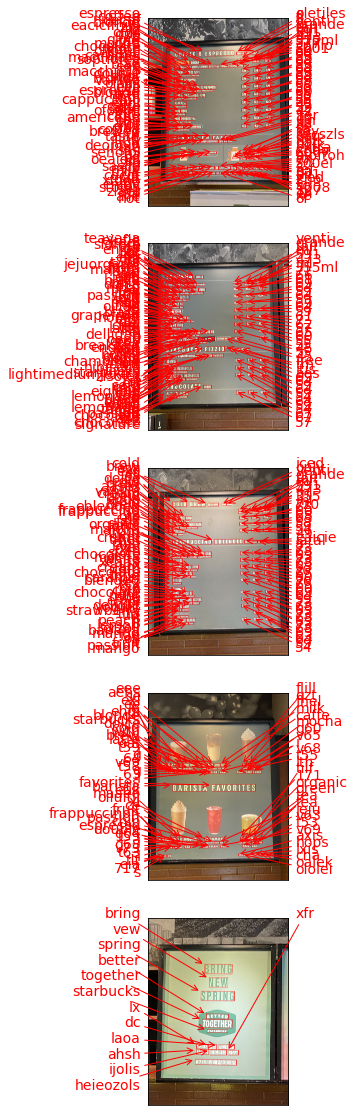

In [19]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## Tesseract

In [53]:
#Tesseract

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/TM_1_tesseract_crop'
img_file_path = os.getenv('HOME') + '/aiffel/ocr_python/TM_1.png' 

cropped_image_path_list_1 = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/TM_1_tesseract_crop/0000.png


In [52]:
recognize_images(cropped_image_path_list_1)
text_list_1 = text_list
print(text_list_1)


Done
['']


In [22]:
#Tesseract

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/TM_2_tesseract_crop'
img_file_path = os.getenv('HOME') + '/aiffel/ocr_python/TM_2.png' 

cropped_image_path_list_2 = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/TM_2_tesseract_crop/0000.png
/aiffel/aiffel/ocr_python/TM_2_tesseract_crop/0001.png
/aiffel/aiffel/ocr_python/TM_2_tesseract_crop/0002.png
/aiffel/aiffel/ocr_python/TM_2_tesseract_crop/0003.png
/aiffel/aiffel/ocr_python/TM_2_tesseract_crop/0004.png
/aiffel/aiffel/ocr_python/TM_2_tesseract_crop/0005.png
/aiffel/aiffel/ocr_python/TM_2_tesseract_crop/0006.png


In [23]:
recognize_images(cropped_image_path_list_2)
text_list_2 = text_list
print(text_list_2)

a


om

any

a

| Pelee |


Done
['a', '', 'om', 'any', 'a', '| Pelee |', '']


In [24]:
#Tesseract

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/TM_3_tesseract_crop'
img_file_path = os.getenv('HOME') + '/aiffel/ocr_python/TM_3.png' 

cropped_image_path_list_3 = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/TM_3_tesseract_crop/0000.png


In [25]:
recognize_images(cropped_image_path_list_3)
text_list_3 = text_list
print(text_list_3)


Done
['']


In [26]:
#Tesseract

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/TM_4_tesseract_crop'
img_file_path = os.getenv('HOME') + '/aiffel/ocr_python/TM_4.png' 

cropped_image_path_list_4 = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/TM_4_tesseract_crop/0000.png
/aiffel/aiffel/ocr_python/TM_4_tesseract_crop/0001.png
/aiffel/aiffel/ocr_python/TM_4_tesseract_crop/0002.png
/aiffel/aiffel/ocr_python/TM_4_tesseract_crop/0003.png
/aiffel/aiffel/ocr_python/TM_4_tesseract_crop/0004.png


In [27]:
recognize_images(cropped_image_path_list_4)
text_list_4 = text_list
print(text_list_4)

ee Meee] Oe

—

2 wee ®t ~

gsr.

:

Done
['ee Meee] Oe', '—', '2 wee ®t ~', 'gsr.', ':']


In [28]:
#Tesseract

work_dir = os.getenv('HOME')+'/aiffel/ocr_python/TM_5_tesseract_crop'
img_file_path = os.getenv('HOME') + '/aiffel/ocr_python/TM_5.png' 

cropped_image_path_list_5 = crop_word_regions(img_file_path, work_dir)

/aiffel/aiffel/ocr_python/TM_5_tesseract_crop/0000.png


In [29]:
recognize_images(cropped_image_path_list_5)
text_list_5 = text_list
print(text_list_5)

[ |

Done
['[ |']


# Step3. 테스트 결과 정리

## Google OCR API 결과

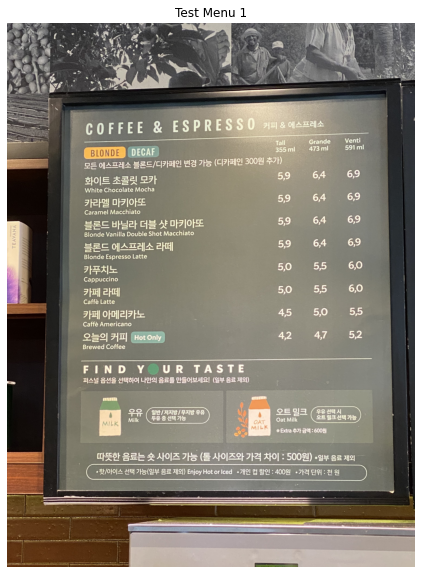

['COFFEE', '&', 'ESPRESS0', '&', '0|AA', 'Tall', '355', 'ml', 'Grande', '473', 'ml', 'Venti', '591', 'ml', 'BLONDE', 'DECAF', '모든', '에스프레소', '블론드', '/', '디카', '페인', '변경', '가능', '(', '디카', '페인', '300', '원', '추가', ')', '5,9', '6,4', '6,9', '화이트', '초콜릿', '모카', 'White', 'Chocolate', 'Mocha', '5,9', '6,4', '6,9', '카라멜', '마키아', '또', 'Caramel', 'Macchiato', '5,9', '6,4', '6,9', '블론드', '바닐라', '더블', '샷', '마키아', '또', 'Blonde', 'Vanilla', 'Double', 'Shot', 'Macchiato', '블론드', '에스프레소', '라떼', '5,9', '6,4', '6,9', 'Blonde', 'Espresso', 'Latte', '카푸치노', '5,0', '5,5', '6,0', 'Cappuccino', '카페', '라떼', '5,0', '5,5', '6,0', 'Caffè', 'Latte', '카페', '아메리카노', '4,5', '5,0', '5,5', 'Caffè', 'Americano', '오늘', '의', '커피', 'Hot', 'Only', '4,2', '4,7', '5,2', 'Brewed', 'Coffee', 'FIND', 'YOUR', 'TASTE', '퍼스널', '옵션', '을', '선택', '하여', '나만', '의', '음료', '를', '만들어', '보세요', '!', '(', '일부', '음료', '제외', ')', '우유', '일반', '/', '저지방', '/', '무', '지방', '우유', '두유', '중', '선택', '가능', '오트', '밀크', '우유', '선택', '시', '오트', '밀크', '선택'

In [36]:
# Test 1
fig = plt.figure(figsize = (10,10))
rows = 1
cols = 1

img1 = cv2.imread(TM1)
 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax1.set_title('Test Menu 1')
ax1.axis("off")
plt.show()

print(google_OCR_API_text_list_TM1[1:])

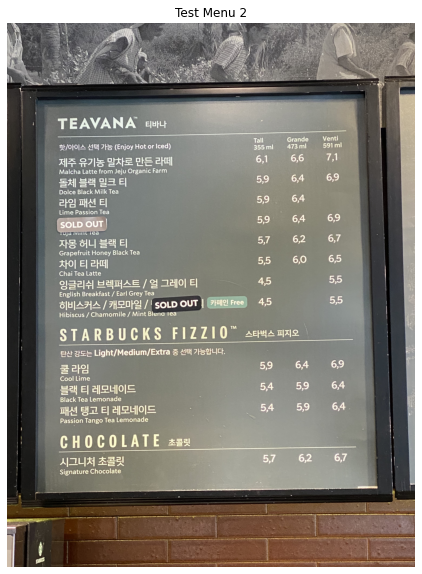

['TEAVANA', 'EJULt', 'TM', 'Tall', '355', 'ml', 'Grande', '473', 'ml', 'Venti', '591', 'ml', '핫', '/', '아이스', '선택', '가능', '(', 'Enjoy', 'Hot', 'or', 'Iced', ')', '제주', '유기농', '말차', '로', '만든', '라떼', '6,1', '6,6', '7,1', 'Malcha', 'Latte', 'from', 'Jeju', 'Organic', 'Farm', '돌체', '블랙', '밀크', '티', '5,9', '6,4', '6,9', 'Dolce', 'Black', 'Milk', 'Tea', '라임', '패션', '티', '5,9', '6,4', 'Lime', 'Passion', 'Tea', '5,9', '6,4', '6,9', 'SOLD', 'OUT', 'Tuja', 'Mint', 'Tea', '자몽', '허니', '블랙', '티', '5,7', '6,2', '6,7', 'Grapefruit', 'Honey', 'Black', 'Tea', '차이', '티', '라떼', '5,5', '6,0', '6,5', 'Chai', 'Tea', 'Latte', '잉글리쉬', '브렉퍼스트', '/', '얼', '그레이', '타', '4,5', '5,5', 'English', 'Breakfast', '/', 'Earl', 'Grey', 'Tea', '히비스커스', '/', '캐모마일', '/', 'SOLD', 'OUT', '카페인', 'Free', '4,5', '5,5', 'Hibiscus', '/', 'Chamomile', '/', 'Mint', 'Blena', 'iea', 'STARBUCKS', 'FIZZIO"', 'AEYA', '스타', '벅스', '피지', '오', '탄산', '강도', '는', 'Light', '/', 'Medium', '/', 'Extra', '중', '선택', '가능', '합니다', '.', '쿨', '라임', '5,9

In [38]:
# Test 2
fig = plt.figure(figsize = (10,10))
rows = 1
cols = 1

img2 = cv2.imread(TM2)
 
ax2 = fig.add_subplot(rows, cols, 1)
ax2.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
ax2.set_title('Test Menu 2')
ax2.axis("off")
plt.show()

print(google_OCR_API_text_list_TM2[1:])

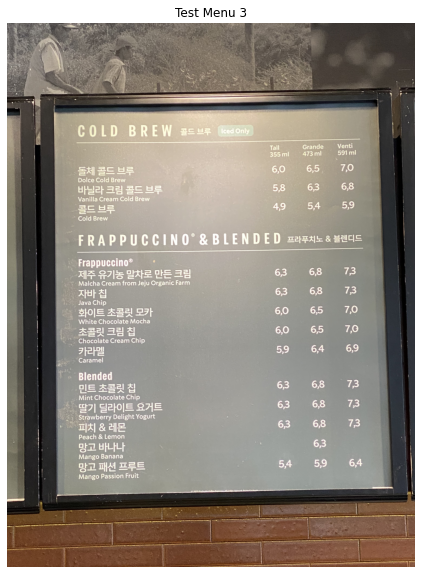

['COLD', 'BREW', 'Iced', 'Only', 'Tall', '355', 'ml', 'Grande', '473', 'ml', 'Venti', '591', 'ml', '돌체', '콜드', '브루', '6,0', '6,5', '7,0', 'Dolce', 'Cold', 'Brew', '바닐라', '크림', '콜드', '브루', '5,8', '6,3', '6,8', 'Vanilla', 'Cream', 'Cold', 'Brew', '콜드', '브루', '4,9', '5,4', '5,9', 'Cold', 'Brew', 'FRAPPUCCINO°', '&', 'BLENDED', '2XE', '&', 'S', 'Frappuccino', '7,3', '제주', '유기농', '말차', '로', '만든', '크림', 'Malcha', 'Cream', 'from', 'Jeju', 'Organic', 'Farm', '6,3', '6,8', '6,3', '6,8', '7,3', '자바', '칩', 'Java', 'Chip', '화이트', '초콜릿', '모카', '6,0', '6,5', '7,0', 'White', 'Chocolate', 'Mocha', '6,0', '6,5', '7,0', '초콜릿', '크림', '칩', 'Chocolate', 'Cream', 'Chip', '카라멜', '5,9', '6,4', '6,9', 'Caramel', 'Blended', '6,3', '6,8', '7,3', '민트', '초콜릿', '칩', 'Mint', 'Chocolate', 'Chip', '6,3', '6,8', '7,3', '딸기', '딜라이트', '요거트', 'Strawberry', 'Delight', 'Yogurt', '피치', '&', '레몬', '6,3', '6,8', '7,3', 'Peach', '&', 'Lemon', '망고', '바나나', '6,3', 'Mango', 'Banana', '망고', '패션', '프루트', '5,4', '5,9', '6,4', 'Mango'

In [41]:
# Test 3
fig = plt.figure(figsize = (10,10))
rows = 1
cols = 1

img3 = cv2.imread(TM3)
 
ax3 = fig.add_subplot(rows, cols, 1)
ax3.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
ax3.set_title('Test Menu 3')
ax3.axis("off")
plt.show()

print(google_OCR_API_text_list_TM3[1:])

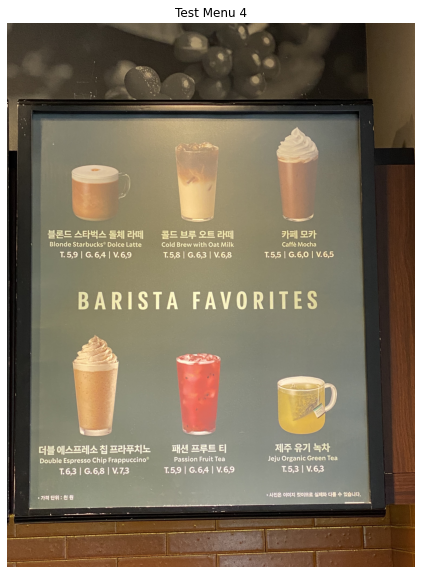

['블론드', '스타', '벅스', '돌체', '라떼', '콜드', '브루', '오트', '라떼', '카페', '모카', 'Blonde', 'Starbucks', 'Dolce', 'Latte', 'Cold', 'Brew', 'with', 'Oat', 'Milk', 'Caffè', 'Mocha', 'T.', '5,9', '|', 'G.', '6,4', '|', 'V.6,9', 'T.5,8', '|', 'G.', '6,3', '|', 'V.', '6,8', 'T.5,5', '|', 'G.6,0', '|', 'V.6,5', 'BARISTA', 'FAVORITES', 'TEAVARA', '더블', '에스프레소', '칩', '프라푸치노', 'Double', 'Espresso', 'Chip', 'Frappuccino', 'T.6,3', '|', 'G.6,8', '|', 'V.7,3', '패션', '프루트', '티', '제주', '유기', '녹차', 'Passion', 'Fruit', 'Tea', 'Jeju', 'Organic', 'Green', 'Tea', 'T.5,9', '|', 'G.6,4', '|', 'V.6,9', 'T.5,3', '|', 'V.6,3', '•', '가격', '단위', ':', '천', '원', '·', '사진', '은', '이미지', '컷', '이므로', '실제', '와', '다를', '수', '있습니다', '.']


In [42]:
# Test 4
fig = plt.figure(figsize = (10,10))
rows = 1
cols = 1

img4 = cv2.imread(TM4)
 
ax4 = fig.add_subplot(rows, cols, 1)
ax4.imshow(cv2.cvtColor(img4, cv2.COLOR_BGR2RGB))
ax4.set_title('Test Menu 4')
ax4.axis("off")
plt.show()

print(google_OCR_API_text_list_TM4[1:])

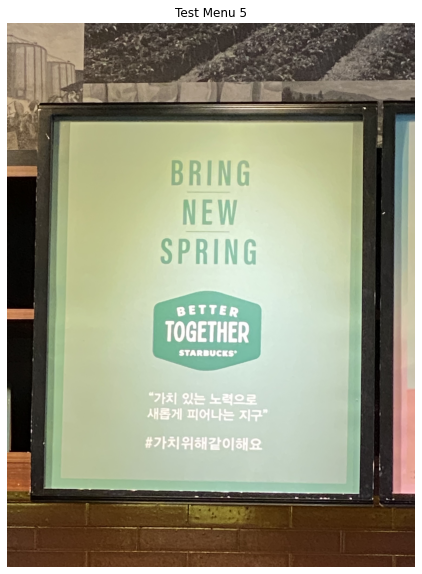

['BRING', 'NEW', 'SPRING', 'BETTER', 'TOGETHER', 'STARBUCKS', '"', '가치', '있는', '노력', '으로', '새롭게', '피어나', '는', '지구', '"', '#', '가치', '위해', '같이', '해요']


In [43]:
# Test 5
fig = plt.figure(figsize = (10,10))
rows = 1
cols = 1

img5 = cv2.imread(TM5)
 
ax5 = fig.add_subplot(rows, cols, 1)
ax5.imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
ax5.set_title('Test Menu 5')
ax5.axis("off")
plt.show()

print(google_OCR_API_text_list_TM5[1:])

## keras-OCR 결과

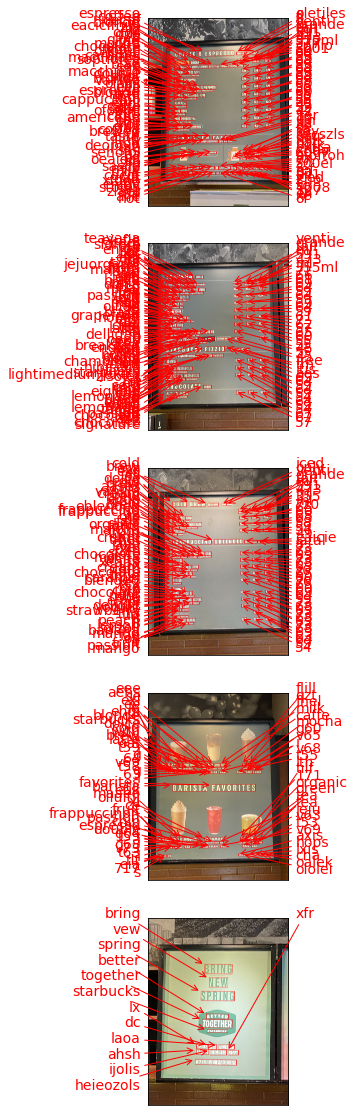

In [44]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

## Tesseract 결과

Image 1에 대한 결과
 ['']


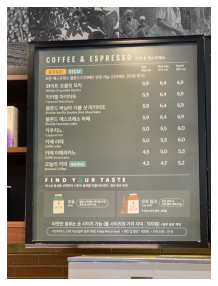

In [58]:
fig = plt.figure(figsize = (5,5))
rows = 1
cols = 1

dirt = os.getenv('HOME')+'/aiffel/ocr_python/TM_1_tesseract_crop'
TC1 = dirt + '/0000.png'

tcimg1 = cv2.imread(TC1)
 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(tcimg1, cv2.COLOR_BGR2RGB))
ax1.set_title(text_list_1[0])
ax1.axis("off")

print("Image 1에 대한 결과\n",text_list_1)
plt.show()

Image 1에 대한 결과
 ['']


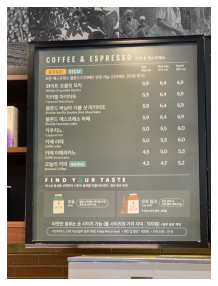

-------------------- 

Image 2에 대한 결과
 ['a', '', 'om', 'any', 'a', '| Pelee |', '']


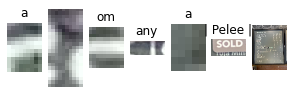

-------------------- 

Image 3에 대한 결과
 ['']


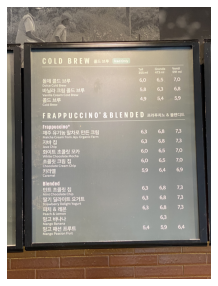

-------------------- 

Image 4에 대한 결과
 ['ee Meee] Oe', '—', '2 wee ®t ~', 'gsr.', ':']


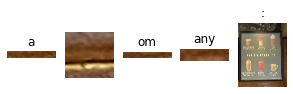

-------------------- 

Image 3에 대한 결과
 ['[ |']


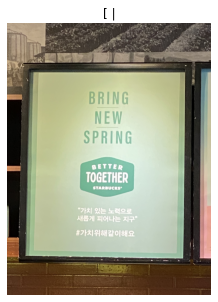

-------------------- 



In [62]:
fig = plt.figure(figsize = (5,5))
rows = 1
cols = 1

dirt = os.getenv('HOME')+'/aiffel/ocr_python/TM_1_tesseract_crop'
TC1 = dirt + '/0000.png'

tcimg1 = cv2.imread(TC1)
 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(tcimg1, cv2.COLOR_BGR2RGB))
ax1.set_title(text_list_1[0])
ax1.axis("off")

print("Image 1에 대한 결과\n",text_list_1)
plt.show()

print("-"*20,'\n')

fig = plt.figure(figsize = (5,5))
rows = 1
cols = 7

dirt = os.getenv('HOME')+'/aiffel/ocr_python/TM_2_tesseract_crop'
TC1 = dirt + '/0000.png'
TC2 = dirt + '/0001.png'
TC3 = dirt + '/0002.png'
TC4 = dirt + '/0003.png'
TC5 = dirt + '/0004.png'
TC6 = dirt + '/0005.png'
TC7 = dirt + '/0006.png'

tcimg1 = cv2.imread(TC1)
tcimg2 = cv2.imread(TC2)
tcimg3 = cv2.imread(TC3)
tcimg4 = cv2.imread(TC4)
tcimg5 = cv2.imread(TC5)
tcimg6 = cv2.imread(TC6)
tcimg7 = cv2.imread(TC7)
 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(tcimg1, cv2.COLOR_BGR2RGB))
ax1.set_title(text_list_2[0])
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(tcimg2, cv2.COLOR_BGR2RGB))
ax2.set_title(text_list_2[1])
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(tcimg3, cv2.COLOR_BGR2RGB))
ax3.set_title(text_list_2[2])
ax3.axis("off")

ax4 = fig.add_subplot(rows, cols, 4)
ax4.imshow(cv2.cvtColor(tcimg4, cv2.COLOR_BGR2RGB))
ax4.set_title(text_list_2[3])
ax4.axis("off")

ax5 = fig.add_subplot(rows, cols, 5)
ax5.imshow(cv2.cvtColor(tcimg5, cv2.COLOR_BGR2RGB))
ax5.set_title(text_list_2[4])
ax5.axis("off")

ax6 = fig.add_subplot(rows, cols, 6)
ax6.imshow(cv2.cvtColor(tcimg6, cv2.COLOR_BGR2RGB))
ax6.set_title(text_list_2[5])
ax6.axis("off")

ax7 = fig.add_subplot(rows, cols, 7)
ax7.imshow(cv2.cvtColor(tcimg7, cv2.COLOR_BGR2RGB))
ax7.set_title(text_list_2[6])
ax7.axis("off")

print("Image 2에 대한 결과\n",text_list_2)
plt.show()

print("-"*20,'\n')

fig = plt.figure(figsize = (5,5))
rows = 1
cols = 1

dirt = os.getenv('HOME')+'/aiffel/ocr_python/TM_3_tesseract_crop'
TC1 = dirt + '/0000.png'

tcimg1 = cv2.imread(TC1)
 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(tcimg1, cv2.COLOR_BGR2RGB))
ax1.set_title(text_list_3[0])
ax1.axis("off")

print("Image 3에 대한 결과\n",text_list_3)
plt.show()

print("-"*20,'\n')

fig = plt.figure(figsize = (5,5))
rows = 1
cols = 5

dirt = os.getenv('HOME')+'/aiffel/ocr_python/TM_4_tesseract_crop'
TC1 = dirt + '/0000.png'
TC2 = dirt + '/0001.png'
TC3 = dirt + '/0002.png'
TC4 = dirt + '/0003.png'
TC5 = dirt + '/0004.png'


tcimg1 = cv2.imread(TC1)
tcimg2 = cv2.imread(TC2)
tcimg3 = cv2.imread(TC3)
tcimg4 = cv2.imread(TC4)
tcimg5 = cv2.imread(TC5)

 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(tcimg1, cv2.COLOR_BGR2RGB))
ax1.set_title(text_list_2[0])
ax1.axis("off")
 
ax2 = fig.add_subplot(rows, cols, 2)
ax2.imshow(cv2.cvtColor(tcimg2, cv2.COLOR_BGR2RGB))
ax2.set_title(text_list_2[1])
ax2.axis("off")

ax3 = fig.add_subplot(rows, cols, 3)
ax3.imshow(cv2.cvtColor(tcimg3, cv2.COLOR_BGR2RGB))
ax3.set_title(text_list_2[2])
ax3.axis("off")

ax4 = fig.add_subplot(rows, cols, 4)
ax4.imshow(cv2.cvtColor(tcimg4, cv2.COLOR_BGR2RGB))
ax4.set_title(text_list_2[3])
ax4.axis("off")

ax5 = fig.add_subplot(rows, cols, 5)
ax5.imshow(cv2.cvtColor(tcimg5, cv2.COLOR_BGR2RGB))
ax5.set_title(text_list_4[4])
ax5.axis("off")

print("Image 4에 대한 결과\n",text_list_4)
plt.show()

print("-"*20,'\n')

fig = plt.figure(figsize = (5,5))
rows = 1
cols = 1

dirt = os.getenv('HOME')+'/aiffel/ocr_python/TM_5_tesseract_crop'
TC1 = dirt + '/0000.png'

tcimg1 = cv2.imread(TC1)
 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(tcimg1, cv2.COLOR_BGR2RGB))
ax1.set_title(text_list_5[0])
ax1.axis("off")

print("Image 3에 대한 결과\n",text_list_5)
plt.show()

print("-"*20,'\n')


In [50]:
print("Image 1에 대한 결과\n",text_list_1,'\n','='*20,'\n')
print("Image 2에 대한 결과\n",text_list_2,'\n','='*20,'\n')
print("Image 3에 대한 결과\n",text_list_3,'\n','='*20,'\n')
print("Image 4에 대한 결과\n",text_list_4,'\n','='*20,'\n')
print("Image 5에 대한 결과\n",text_list_5,'\n','='*20,'\n')

Image 1에 대한 결과
 [''] 

Image 2에 대한 결과
 ['a', '', 'om', 'any', 'a', '| Pelee |', ''] 

Image 3에 대한 결과
 [''] 

Image 4에 대한 결과
 ['ee Meee] Oe', '—', '2 wee ®t ~', 'gsr.', ':'] 

Image 5에 대한 결과
 ['[ |'] 



# Step4. 결과 분석과 결론 제시

## 결과 분석

### 서비스 기획
- 한글과 영문이 혼용 되어 있는 글자를 인식해 본다.

### 평가기준
1. 한글은 한글, 영문은 영문에 대한 인식률을 확인해 본다.
2. 또한 카페 조명 특성상 조명에 가려진 노이즈도 인식하는지 확인해 본다.
3. 또한, 아주 작은 글자까지 인식을 하는지 확인해 본다.

---
### Google OCR-API
- Google OCR-API같은 경우, 한글과 영문을 따로 구분해 주지 않았는데도 알아서 한글과, 영문을 모두 구분하여 인식하였다.
- Image 1 에서 카페 조명으로 인해 빛에 가려진 글자 '커피 & 에스프레스' 의 경우에는, '0|AA' 라고 불량 인식을 하였다.
- 하지만 Image 3의 'Iced Only' 같은 경우에는 똑같이 조명에 가려졌음에도 잘 인식하였다.
- 확대한 사진이어서 환벽한 고화질의 사진이 아니었음에도, 작은 글자까지 모두 성공적으로 인식하는 모습을 확인할 수 있었다.

### Keras - OCR
- 글자 자체로는 작은 글자, 빛이 섞인 노이즈 글자 등에 대한 글자 인식률은 성공적으로 해낸 모습을 확인할 수 있었다.
- 한글을 따로 인식시킬 수 있는 방법이 있는지는 모르겠지만 한글은 전혀 인식하지 못하여, 글자는 인식하였지만, 엉뚱한 영문을 출력해 내었다.

### Tesseract
- 한글, 영문 모두 제대로 인식하지 못하였다.
- 그나마 몇 가지 crop을 하긴 하였으나, 글자에 대해서는 전혀 crop하지 못하였고, Image 2같은경우, 'SOLD' 라는 글자를 인식하긴 하였으나, 출력값은 '| Pelee |' 이라는 이상한 글자를 출력하였다.

## 결론 제시
#### 서비스 의도에 가장 적합한 모델은 Google OCR-API를 이용하는 것 이었다.
- Keras-OCR의 경우에도, 작은글씨, 그리고 노이즈까지 집아내었고, 글자 인식에 대해서는 훌륭한 성능을 보여주었으나, 서비스 기획 의도에서 말하였듯, 한글과 영문 혼용된 메뉴판을 읽기에는, 영문 한정으로만 인식하였기 때문에 Google OCR-API를 이용하는것이 가장 좋다는 결론을 내어 봅니다.

# 회고
## 이번 프로젝트에서 어려웠던 점.
#### 이번 프로젝트에서 어려웠던 점은 우선 서비스를 기획하는점 이었습니다.
- 이전에 했던 노드들과는 다르게, 이전에는 코드를 구현하는 부분에서 머리를 써 보았다면, 이번에는 처음으로 이미 되어있는 기술을 어떤식으로 적용할지에 대한 부분이었기 때문에, 아이디어를 생각하는 측면에서 어려웠습니다

## 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점.
#### 생각보다 훌륭한 성능을 보여준 다는 것을 알아내었습니다.
- 처음 이 아이디어를 기획하게 된 이유는, 우연히 영문과 한글이 혼용되어 있는 사진을 이용하였는데, 이를 인식한다는 점에서 시작하게 되었습니다. 따로 설정을 해주지 않았는데, Google OCR-API는 이미 한글과 영어를 구분한다는 점에서 놀랐습니다.

- 또한 만들어진 모델을 사용하는것 이었지만, 제가 찍은 사진에서, 아 이건 글씨가 사람도 알아보기 쉽지 않을 정도로 작은데 잘 인식할까? 하는 부분까지 인식을 시켜주는 부분에서 정말 놀랐습니다.

#### 하지만, 인식하지 못하는 글자에 대해 어떻게 개선시켜야할지 아직 모호합니다.
- 위의 실험에서 노이즈(제 경우에는 조명에 의한 빛에 가려진 글자)에 가려 인식하지 못하는 글자가 있었는데, 이를 개선하거나, 혹은 다시 재 라벨링을 하고싶을 때에 방법이 있는지가 궁금하습니다.

#### Keras-OCR은 한글, 영어 혼용된 사진을 이용하려면 어떻게 섞어야할지도 궁금하였습니다.
- 사실 Keras-OCR역시 글자 자체 인식은 훌륭하였기 때문에, ENG와, KOR둘 다 구분하여 인식시킬 수 있다면 괜찮은 성능을 보여줄 것으로 생각하였는데, 그 방법에 대해 알아내지 못하였습니다.

## 루브릭 평가 지표를 맞추기 위해 시도한 것들
#### 목표로 하는 서비스가 OCR 적용 가능하며, 활용하였을 때 유용해 지는가.
- 아무래도 메뉴판은 대부분 글자로 되어있기에 적합하다고 생각하였고, 또한 요즘 점점 한글과 영어를 혼용하여 쓰는 메뉴판 및 표지판이 늘고있다고 생각하여 이를 활용하여 서비스를 만들면 유용할 것으로 생각하였습니다.

#### 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
- 우선적으로 영어와, 한글이 모두 한 사진안에 들어가 있는 메뉴판을 선택하였습니다.
- 또한 카페의 조명이 사진찍으려 하였을 때 메뉴의 일부 글자를 가리기 때문에, 일부러 이를 포함하여 사진을 실험해 보았습니다.
- 마지막으로, 메뉴판 안에 매우 작은 글자가 있는데, 심지어 거리가 다소 있어, 핸드폰 카메라의 줌 기능을 사용하여 화질이 다소 낮아졌는데, 화질이 다소 낮은, 작은 글자까지 인식하는가를 보기위한 사진까지 선택하여 적용해 보았습니다.

#### 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.
- 이 부분을 개선하기 위해, STEP 3 결과 부분에서, 알아보고자하는 이미지, 그리고 결과를 한눈에 볼 수 있는 출력값으로 보여주기 위해 코드를 작성해 보았습니다.
- 사실 아직 파이썬 코드 구현이 익숙하지 않기에, 좀 더 간단한 코드를 사용 할 수 도 있음에도, 그렇게 구현하지 못하여 하나하나 노가다로 만들어 낸 코드이기 때문에 다소 코드가 길어서 평가하시는 분이 읽어 내기에 좋지는 않지만, 출력 결과적으로는 실험하고자 하는 이미지와, 그에 따른 결과를 잘 구분해 내었습니다.

## 만약에 루브릭 평가 관련 지표를 달성하지 못했을 때, 이유에 관한 추정
#### 루브릭 평가를 달성하지 못하였다면, 아무래도 적은 대조군을 추정해 봅니다.
- 5개 남짓의 사진을 사용하였고, 좀 더 열악한 환경의 이미지를 실험하지 않았고, 나름 꽤 깨끗하고 정제 된 이미지를 사용하여 좋은 정확도의 결과를 보여준것이 관련 지표를 달성하지 못한 이유가 되지 않을까 추정해 봅니다.

## 자기 다짐
- 이번 노드를 통하여 훌륭한 OCR기술이 이미 잘 구현되어 있다는 점을 알게 되었습니다. 서비스를 기획하게 된 첫 시작은, 자료를 구하기가 어려워, 당장 내 눈앞에 있는 글자를 찾아내 보려다가, 눈 앞에 수많은 글자들의 향연인 메뉴판을 보게 되었습니다. 우선적으로 이걸 인식시켜보고자 사진을 찍어 모델을 확인해 보았는데, 기대치 않게 한글과 영문 두 가지를 모두 동시에 인식시키는 Google OCR API를 확인한것이 서비스 아이디어의 시작이 되었습니다. 이를통해, 최근 메뉴판 혹은, 표지판 등이 영문이 점점 많아진다는 사실을 깨닫게 되었고, 이를 혹시나 서비스화 하면 영문, 한글 혹은 다른나라 언어 까지 포함하여 괜찮은 서비스로 만들 수 있겠다는 생각으로 아이디어가 확장될 수 있었습니다.
- 비록, 만들어진 기술을 자유롭게 원하는 방향으로, 그리고 잘못된 인식에 대해 내가 개선할 수 있는 그정도로 깊게 알지는 못하였지만, 이런 기술의 존재를 알게된 것만으로도 앞으로 내가 어떤식으로 공부하고 어떤 방향으로 향해야 할 지에대한 지표가 약간 상승하게 되었습니다.
- 또한, 이전 노드에는 코드를 위해 머리를 썼으면, 이번에는 어떤 서비스로 이 기술을 확장시키면 좋을까, 에 대한 아이디어적인 부분이 재미있었고, 이런 생각 훈련이 좋은 훈련이라고 생각하였습니다.
- 항상 노드를 진행하며, 내가 생각한 미래라고 생각한 부분들은 이미 휼륭하게 구현되어있음에 항살 실로 놀랍니다. 때문에 남들이 생각하지 못한, 혹은 아직 헤내지 못한 기술까지 내가 할 수 있도록 공부하는것이 공부를 하며 최종 목표로 삼아야 겠다 다짐해 봅니다.